# Estimate the parasitic neutron attenuation in the target

- import kaeri data
- calculate (averaged) cross sections
- calculate attenuation coefficient
- compute fraction of attenuated neutrons

In [120]:
import pandas as pd
import numpy as np

In [121]:
Na = 6.022e23 # 1/mol
properties_Cu = {'material': 'copper',
                 'isotopes': ['Cu-63', 'Cu-65'],
                 'density': 8.96,
                 'abundances': [69.15/100, 30.85/100],
                 'Mol': 63.546
             }

properties_H2O = {'material': 'water',
                 'isotopes': ['H-1', 'O-16'],
                 'density': 1,
                 'abundances': [2, 1],
                 'Mol': 18.01528
             }

properties_Ti = {'material': 'titanium',
                 'isotopes': ['Ti-46', 'Ti-47', 'Ti-48', 'Ti-49', 'Ti-50'],
                 'density': 4.506,
                 'abundances': [8.25/100, 7.44/100, 73.72/100, 5.41/100, 5.18/100],
                 'Mol': 47.867
             }
properties = {'Cu': properties_Cu,
             'H2O': properties_H2O,
             'Ti': properties_Ti}

data = pd.DataFrame(index = [
                'rho', # g/cm3
                'mol', # g/mol
                'sigma', # cm2
                'SIGMA'# 1/cm
             ])


In [122]:
# get the microscopic attenuation coefficient
path = '/Users/hkromer/02_PhD/02_Data/04.xs/'

for material in properties.keys():
    abundances = properties[material]['abundances']
    isotopes = properties[material]['isotopes']

    xs = []

    for a, i in zip(abundances, isotopes):
        sig = pd.read_csv(f'{path}/{i}.n_tot.txt', skiprows=1, header=0, delimiter=' ')
        cols = ['E', 'xs']
        # energy in eV, xs in barn
        sig.columns = cols
        # select only range from 2 to 3 MeV
        sig = sig[ (sig['E'] >= 2.4e6) & ((sig['E'] <= 2.6e6)) ]

        sig_av = sig['xs'].mean() # average in 2-3 MeV range
        sig_av = sig_av * 1e-24 # convert to cm2
#         print(material, i, sig_av)
        xs.append(sig_av)


    xs = np.array(xs)
    ab = np.array(abundances)
#     print(xs, abundances)
    sigma = np.sum(xs * ab)
    properties[material]['xs'] = xs
    
    properties[material]['sigma'] = sigma
for material in properties.keys():
    rho = properties[material]['density']
    sigma = properties[material]['sigma']
    mol = properties[material]['Mol']
    data[material] = [
                    rho, # g/cm3
                    mol,
                    sigma, # cm2
                    0 # 1/cm
                 ]

data.T['SIGMA'] = Na * data.T['sigma'] * data.T['rho'] / data.T['mol']
data

,Cu,H2O,Ti
rho,8.960000e+00,1.000000e+00,4.506000e+00
mol,6.354600e+01,1.801528e+01,4.786700e+01
sigma,3.142665e-24,6.034756e-24,3.644807e-24
SIGMA,2.668447e-01,2.017249e-01,2.066190e-01


In [123]:
data.loc['SIGMA', 'H2O']

0.20172488108746203

In [106]:
d_Cu = 3/10
d_Cu = (d_Cu/10)*2
np.exp(-data.loc['SIGMA', 'Cu'] * d_Cu)

0.9841168049315571

In [126]:
# thicknesses in mm
d_Cus = np.arange(1, 8, 1)*2 # target wall
d_walls = np.arange(1, 4, 1)*4 # thickness of the pipe
d_waters = np.arange(1, 5, 1)*4

def get_attenuated_fraction(data, d_water, d_Cu, d_wall, d_Ti):  # d are in mm! 
    """
    Get the attenuated fraction of neutrons (1 - I/I0) for thicknesses of water, copper wall, titanium which are in mm
    """
    # the onion structure of the target means that copper (CuOFE) is passed through twice
    d_Cu = (d_Cu/10)
    f_Cu = np.exp(- data.loc['SIGMA', 'Cu'] * d_Cu)
    
    # walls are passed four times
    d_wall = (d_wall/10)
    f_wall = np.exp(-data.loc['SIGMA', 'Cu'] * d_wall)
    
    # titanium is passed twice
    d_Ti = (d_Ti/10)
    f_Ti = np.exp(-data.loc['SIGMA', 'Ti'] * d_Ti)
    
    # water is passed four times
    d_water = (d_water/10)
    f_water = np.exp(-data.loc['SIGMA', 'H2O'] * d_water)

    return (1-(f_Cu * f_wall * f_Ti * f_water))*100 # 

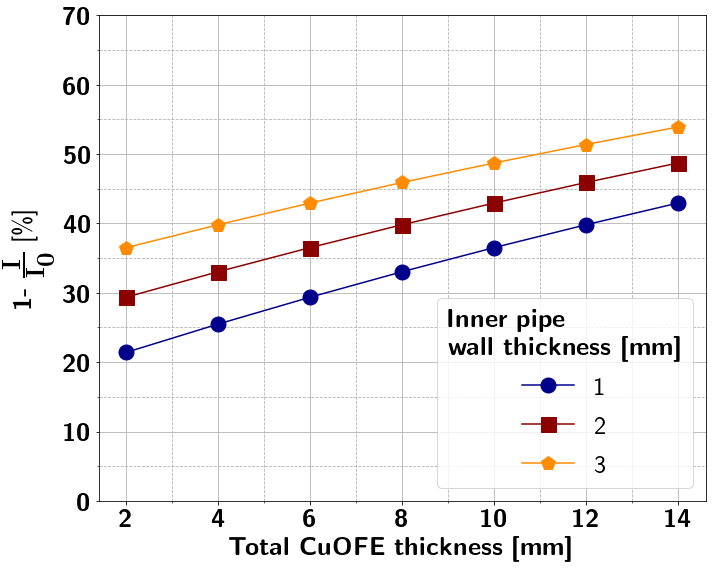

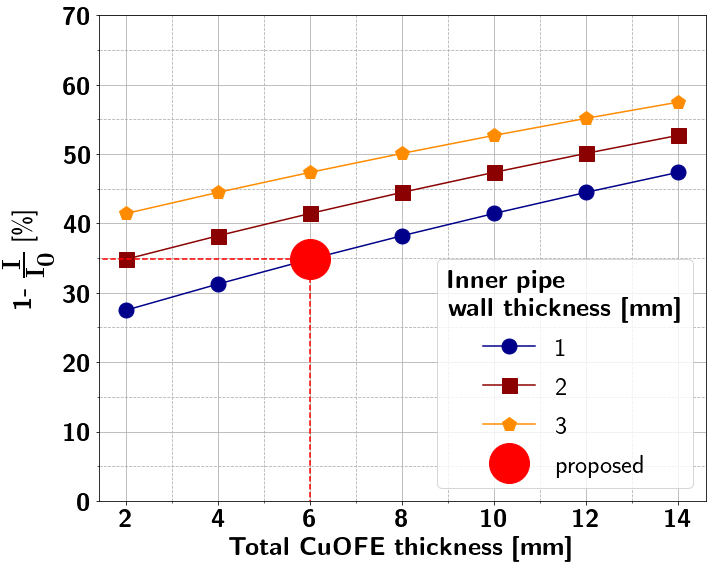

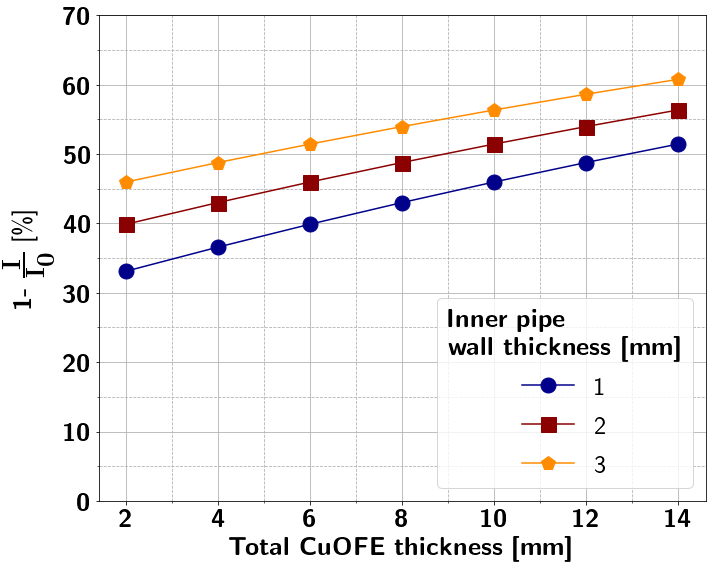

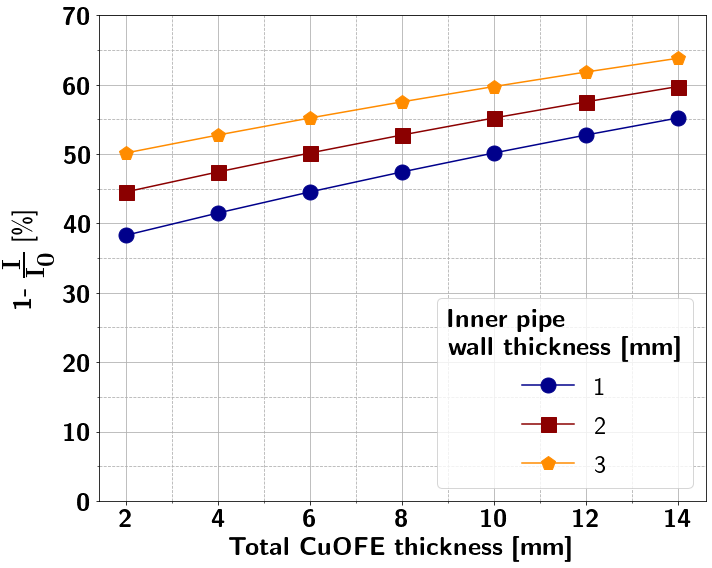

In [135]:
import numpy as np
import pandas as pd
import os
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import os
import matplotlib
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


folder = '/Users/hkromer/polybox/Thesis/Chapters/RotatingIonBeamTarget/Figures/parasitic_attenuation/'
colors = ['darkblue', 'darkred', 'darkorange']
markers = ['o', 's', 'p']
fs = 16+10
ls = 16+10
d_Ti = 5e-3

for d_water in d_waters:
    plt.figure(figsize=(10,8))
    for c, m, d_wall  in zip(colors, markers, d_walls):
        # plot
        X = d_Cus
        Y = get_attenuated_fraction(data, d_water, d_Cus, d_wall, d_Ti)
#         plt.plot(d_Cus, fracAttNeutrons(properties, d_water, d_Cus, d_wall, d_Ti), marker=m, markersize=15, c=c, label=f'{d_wall}')
        plt.plot(X, Y, marker=m, markersize=15, c=c, label=f'{int(d_wall/4)}')
    if int(d_water) == 8:
        X = [6]
        Y = [get_attenuated_fraction(data, 8, 6, 4, 10e-3)]
        plt.plot(X, Y, marker='.', linestyle='None', color='red', markersize=80, label='proposed')
        
        xlims = plt.gca().get_xlim()
        
        X = [-10, 6]
        Y = [get_attenuated_fraction(data, 8, 6, 4, 10e-3), get_attenuated_fraction(data, 8, 6, 4, 10e-3)]
        plt.plot(X, Y, color='red', linestyle='dashed', label=None)
        
        X = [6, 6]
        Y = [-10, get_attenuated_fraction(data, 8, 6, 4, 10e-3)]
        plt.plot(X,Y, color='red', linestyle='dashed', label=None)
        plt.xlim(xlims)
    ax = plt.gca()
#     ylim = ax.get_ylim()
#     plt.ylim(ylim)
    ax.tick_params(axis = 'both', which = 'major', labelsize = ls)
#     ax.text(-17.5, 365, r'\textbf{Cu}', color='black', fontsize=fs)
#     ax.text(-16.75, 365, r'\textbf{Water}', color='black', fontsize=fs)
    plt.grid()
    plt.xlabel(r'\textbf{Total CuOFE thickness [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{1-} $\frac{\textrm{\textbf{I}}}{\textrm{\textbf{I}}_{\textrm{\textbf{0}}}}$ [\%]', fontsize=fs)
    plt.ylim(0, 70)
    handles,labels = ax.get_legend_handles_labels()

    if len(handles) > 3:
        handles = [handles[0], handles[1], handles[2], handles[3]]
        labels = [labels[0], labels[1], labels[2], labels[3]]
    else:
        handles = [handles[0], handles[1], handles[2]]
        labels = [labels[0], labels[1], labels[2]]

    legend = ax.legend(handles,labels,title=r'\textbf{Inner pipe}' + '\n'+ r'\textbf{wall thickness [mm]}',loc='lower right', fontsize=fs)
#     plt.title('Water layer thickness ' + str(d_water) + r' mm', fontsize=fs)
    # minor ticks x
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    # minor ticks y
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    # grid
    ax.grid(b=True, which='major', linestyle='-')#, color='gray')
    ax.grid(b=True, which='minor', linestyle='--')#, color='gray')   
    plt.setp(legend.get_title(),fontsize=fs)
    plt.tight_layout()
    plt.savefig(f'{folder}/parasitic_attenuation_d_water_{d_water}mm.pdf', dpi=600)
    
    plt.show()
    plt.close()
    

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [2]:
import os
import matplotlib
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

In [5]:
properties_Cu = {'material': 'copper',
                 'isotopes': ['Cu-63', 'Cu-65'],
                 'density': 8.96,
                 'abundances': [69.15/100, 30.85/100],
                 'Mol': 63.546
             }

properties_H2O = {'material': 'water',
                 'isotopes': ['H-1', 'O-16'],
                 'density': 1,
                 'abundances': [2/18, 16/18],
                 'Mol': 18.01528
             }

properties_Ti = {'material': 'titanium',
                 'isotopes': ['Ti-46', 'Ti-47', 'Ti-48', 'Ti-49', 'Ti-50'],
                 'density': 4.506,
                 'abundances': [8.25/100, 7.44/100, 73.72/100, 5.41/100, 5.18/100],
                 'Mol': 47.867
             }

data = pd.DataFrame()
data.index = [
                'material', 
                'density', # g/cm3
                'sigma', # cm2
                'SIGMA'# 1/cm
             ]
data

ValueError: Length mismatch: Expected axis has 0 elements, new values have 4 elements

In [4]:
# get the microscopic attenuation coefficient
path = '/Users/hkromer/02_PhD/02_Data/04.xs/'

for material in properties.keys():
    abundances = properties[material]['abundances']
    isotopes = properties[material]['isotopes']

    xs = []

    for a, i in zip(abundances, isotopes):
        sig = pd.read_csv(f'{path}/{i}.n_tot.txt', skiprows=1, header=0, delimiter=' ')
        cols = ['E', 'xs']
        # energy in eV, xs in 1e-24cm**2
        sig.columns = cols
        # select only range from 2 to 3 MeV
        sig = sig[ (sig['E'] >= 2e6) & ((sig['E'] <= 3e6)) ]

        sig_av = sig['xs'].mean() # average in 2-3 MeV range
        sig_av = sig_av * 1e-24 # convert to cm2
        print(material, sig_av)
        xs.append(sig_av)

    xs = np.array(xs)
    ab = np.array(abundances)

    sigma = np.sum(xs * ab)
    
    properties[material]['sigma'] = sigma
    


Cu 3.1514264102564103e-24
Cu 3.133873571428571e-24
H2O 2.569463333333333e-24
H2O 8.438504666666666e-25
Ti 3.659402222222222e-24
Ti 3.7341725000000005e-24
Ti 3.443489266055046e-24
Ti 3.828247999999998e-24
Ti 3.85398125e-24


In [5]:
# calculates the macroscopic cross section (attenuation coefficient)
def Sigma(rho, Mol, sigma):
    N_avog = 6.022e23
    return (N_avog*rho/Mol)*sigma

for material in properties.keys():
    xs = properties[material]['sigma']
    rho = properties[material]['density']
    Mol = properties[material]['Mol']
    
    properties[material]['att_coeff'] = Sigma(rho, Mol, xs)
    


In [6]:
properties['Ti']

{'material': 'titanium',
 'isotopes': ['Ti-46', 'Ti-47', 'Ti-48', 'Ti-49', 'Ti-50'],
 'density': 4.506,
 'abundances': [0.0825, 0.07440000000000001, 0.7372, 0.0541, 0.0518],
 'Mol': 47.867,
 'sigma': 3.525007849819113e-24,
 'att_coeff': 0.19982775880226003}

In [7]:
properties['Cu']

{'material': 'copper',
 'isotopes': ['Cu-63', 'Cu-65'],
 'density': 8.96,
 'abundances': [0.6915, 0.3085],
 'Mol': 63.546,
 'sigma': 3.1460113594780217e-24,
 'att_coeff': 0.2671288711244119}

In [8]:
properties['H2O']

{'material': 'water',
 'isotopes': ['H-1', 'O-16'],
 'density': 1,
 'abundances': [2, 1],
 'Mol': 18.01528,
 'sigma': 5.982777133333333e-24,
 'att_coeff': 0.199987365708073}

## Compute fraction of attenuated neutrons

In [13]:
fracAttNeutrons(properties, 200, 0, 0, 0)

99.99998873510236

Make a plot for each water thickness. The different lines are for different wall thicknesses. The x axis is the copper layer thickness (the outer copper layer), the y axis is the fraction of attenuated neutrons.

In [119]:
def fracAttNeutrons(prop, d_water, d_Cu, d_wall, d_Ti):  # d are in mm! 
    # prop is the properties dictionary 
    # Cu
    f_Cu = np.exp(-prop['Cu']['att_coeff'] * (d_Cu/10)*2)
    f_wall = np.exp(-prop['Cu']['att_coeff'] * (d_wall/10)*4)
    f_Ti = np.exp(-prop['Ti']['att_coeff'] * (d_Ti/10)*2)
    f_water = np.exp(-prop['H2O']['att_coeff'] * (d_water/10)*4)
    return (1-(f_Cu * f_wall * f_Ti * f_water))*100

folder = '/Users/hkromer/polybox/Thesis/Chapters/RotatingIonBeamTarget/Figures/parasitic_attenuation/'
colors = ['darkblue', 'darkred', 'darkorange']
markers = ['o', 's', 'p']
fs = 16+10
ls = 16+10
d_Ti = 5e-3

for d_water in d_waters:
    plt.figure(figsize=(10,8))
    for c, m, d_wall  in zip(colors, markers, d_walls):
        # plot
        plt.plot(d_Cus, fracAttNeutrons(properties, d_water, d_Cus, d_wall, d_Ti), marker=m, markersize=15, c=c, label=f'{d_wall}')
    if int(d_water) == 2:
        plt.plot([3], [fracAttNeutrons(properties, 2, 3, 1, 5e-3)], marker='.', linestyle='None', color='red', markersize=80, label='proposed')
        xlims = plt.gca().get_xlim()
        plt.plot([-10, 3],[fracAttNeutrons(properties, 2, 3, 1, 5e-3), fracAttNeutrons(properties, 2, 3, 1, 5e-3)], color='red', linestyle='dashed', label=None)
        plt.plot([3, 3],[-10, fracAttNeutrons(properties, 2, 3, 1, 5e-3)], color='red', linestyle='dashed', label=None)
        plt.xlim(xlims)
    ax = plt.gca()
#     ylim = ax.get_ylim()
#     plt.ylim(ylim)
    ax.tick_params(axis = 'both', which = 'major', labelsize = ls)
#     ax.text(-17.5, 365, r'\textbf{Cu}', color='black', fontsize=fs)
#     ax.text(-16.75, 365, r'\textbf{Water}', color='black', fontsize=fs)
    plt.grid()
    plt.xlabel(r'\textbf{CuOFE thickness [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{1-} $\frac{\textrm{\textbf{I}}}{\textrm{\textbf{I}}_{\textrm{\textbf{0}}}}$ [\%]', fontsize=fs)
    plt.ylim(0, 70)
    handles,labels = ax.get_legend_handles_labels()

    if len(handles) > 3:
        handles = [handles[0], handles[1], handles[2], handles[3]]
        labels = [labels[0], labels[1], labels[2], labels[3]]
    else:
        handles = [handles[0], handles[1], handles[2]]
        labels = [labels[0], labels[1], labels[2]]

    legend = ax.legend(handles,labels,title=r'\textbf{Pipe wall thickness [mm]}',loc='lower right', fontsize=fs)
#     plt.title('Water layer thickness ' + str(d_water) + r' mm', fontsize=fs)
    # minor ticks x
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    # minor ticks y
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    # grid
    ax.grid(b=True, which='major', linestyle='-')#, color='gray')
    ax.grid(b=True, which='minor', linestyle='--')#, color='gray')   
    plt.setp(legend.get_title(),fontsize=fs)
    plt.tight_layout()
    plt.savefig(f'{folder}/parasitic_attenuation_d_water_{d_water}mm.pdf', dpi=600)
    
    plt.show()
    plt.close()
    
fracAttNeutrons(properties, 2, 3, 1, 5e-3)

KeyError: 'att_coeff'

<Figure size 720x576 with 0 Axes>

In [11]:
u = 1.66054e-27 # kg
m_Ti = 47.867 * u # kg
m_e = 9.10938356e-31 # kg
m_Ti/m_e

87256.2535724426